## K-Nearest Neighbors

--------------------------------------------------------------------------------------------------------------------------------------

In [2]:
from typing import List, NamedTuple
from collections import Counter

O modelo de classificação baseada nos vizinhos mais próximos é um dos mais simples, já que não parte de hipóteses matemáticas e sim de: 
* Noções de distância 
* Uma hipótese dobre a semelhança entre pontos próximos

Nesse caso, os pontos dados são vetores. Imagine que escolhemos um número k como 3 ou 5. Em seguida, para classificar novos pontos de dados, devemos encontrar os k pontos rotulados mais próximos e recebemos seus votos na nova saída. 

In [8]:
def maioria_votos(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert maioria_votos(['a','b','c','b']) == 'b'

def maioria_votos_melhorado(labels: List[str]) -> str:
    """
    Essa função recebe uma lista de strings e retorna a 
    string com maior frequência. Também supõe que os rótulos
    estão classificados do mais próximo para o mais distante
    e usa o k-nearest neighbors para o desempate.
    """

    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count for count in vote_counts.values()
                       if count == winner_count])
    if num_winners == 1:
        return winner
    
    else: 
        return maioria_votos_melhorado(labels[:-1]) # tente novamente sem o mais distante
    
assert maioria_votos_melhorado(['a', 'b', 'c', 'a', 'b']) == 'a'


In [3]:
# Funções que serão utilizadas
Vector = List[float]

def subtract(v: Vector, w: Vector) -> Vector:
    """Soma os elementos correspondentes"""
    assert len(v) == len(w), 'Os vetores devem ser do mesmo tamanho'
    return [v_i - w_i for v_i, w_i in zip(v, w)]
def dot(v: Vector, w: Vector) -> float:
    """Calcula o produto de dois vetores, v_1 * w_1 + v_2 * w_2..."""
    assert len(v) == len(w), 'as funções não têm o mesmo tamanho'

    return sum(v_i * w_i for v_i, w_i in zip(v, w))
def distance(v: Vector, w: Vector) -> float:
    """Calcula a distância entre dois vetores"""
    return dot((subtract(v, w)),(subtract(v, w)))**(1/2)

In [10]:
class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int, labeled_points: List[LabeledPoint], new_point: Vector) -> str:
    """Essa função classifica os pontos rotulados do mais próximo para o mais distente,
    encontra os rótulos dos k mais próximos e recebe seus votos"""

    by_distance = sorted(labeled_points, key=lambda lp: distance(lp.point, new_point))
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    return maioria_votos_melhorado(k_nearest_labels)

#### Usando o conjunto de dados Iris como exemplo

In [11]:
import requests

data = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')

with open('iris.dat', 'w') as f:
    f.write(data.text)

In [28]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[list]) -> LabeledPoint:
    """sepal_length, sepal_width, petal_length, petal_width, class"""
    tamanhos = [float(value) for value in row[:-1]]
    # a classe é p. ex. "Iris-virginica"; queremos só "virginica"
    label = row[-1].split('-')[-1]

    return LabeledPoint(tamanhos, label)

with open('iris.dat') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader]

# Também agruparemos apenas os pontos por espécie/rótulo para plotá-los
pontos_por_especies: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    pontos_por_especies[iris.label].append(iris.point)

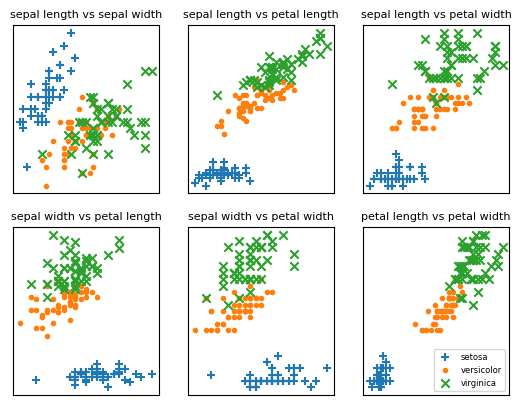

In [31]:
# Visualizando

import matplotlib.pyplot as plt

metricas = ['sepal length', 'sepal width', 'petal length', 'petal width']
pares = [(i,j) for i in range(4) for j in range(4) if i < j]
marcadores = ['+', '.', 'x'] # um para cada tipo de flor

fig, ax = plt.subplots(2,3)

for row in range(2):
    for col in range(3):
        i, j = pares[3 * row + col]
        ax[row][col].set_title(f'{metricas[i]} vs {metricas[j]}', fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marcadores, pontos_por_especies.items()):
            xs = [pont[i] for pont in points]
            ys = [pont[j] for pont in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})

In [32]:
import random
from typing import TypeVar, Tuple
X = TypeVar("X")
def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Essa função divide os dados em frações (prob, 1 - prob)"""

    data = data[:]
    random.shuffle(data)
    cut = int(len(data) * prob)
    return data[:cut], data[cut:]

random.seed(12)

iris_train, iris_test = split_data(iris_data, 0.7)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

In [33]:
# Conte quantas vezes identificamos (previsto, real)
confusion_matriz: Dict[Tuple[str, str], int] = defaultdict(int)
num_correto = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correto += 1

    confusion_matriz[(predicted, actual)] +=1

pct_correto = num_correto / len(iris_test)
print(pct_correto, confusion_matriz)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


Problemas quanto à dimensionalidade

In [34]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

In [35]:
import tqdm
random.seed(0)

dimensions = range(1, 101)

avg_distances = []
min_distances = []

for dim in tqdm.tqdm(dimensions, desc="Maldição da dimensionalidade"):
    distances = random_distances(dim, 10000) # 10000 pares aleatórios
    avg_distances.append(sum(distances) / 10000)
    min_distances.append(min(distances))

Maldição da dimensionalidade: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


Text(0.5, 0, 'n° de dimensões')

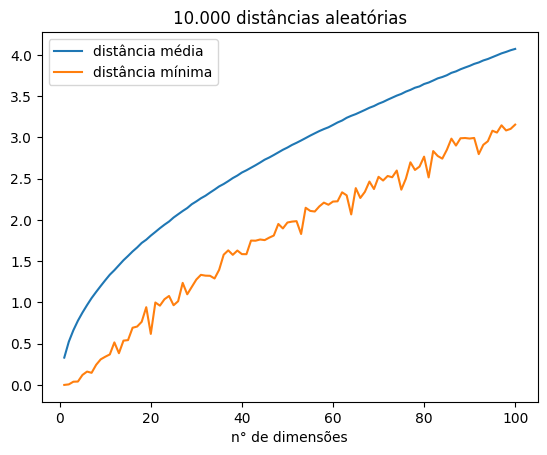

In [42]:
plt.plot(dimensions, avg_distances, label=("distância média"))
plt.plot(dimensions, min_distances, label="distância mínima")
plt.title("10.000 distâncias aleatórias")
plt.legend(loc=2)
plt.xlabel('n° de dimensões')

Text(0.5, 0, 'n° de dimensões')

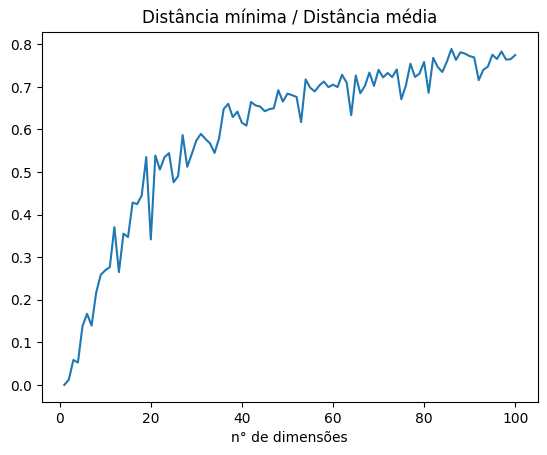

In [43]:
min_avg_ratio = [min_dist / avg_dist for min_dist, avg_dist in zip(min_distances, avg_distances)]

plt.plot(dimensions, min_avg_ratio)
plt.title("Distância mínima / Distância média")
plt.xlabel('n° de dimensões')

É possível que com mais dimensões os pontos estejam mais distantes ou mais pertos